In [1]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
import os
from xcube.core.new import new_cube
from xcube.core.store import new_data_store

## Out-of-core computation in AVL using the power of a dask cluster

The following is a simple example demonstrating how to execute a processing task that is too large to be executed with the resources of the Jupyter Notebook. It involves the usage of a dask processing cluster, which seperates large tasks into chunk-wise operations. 

In [2]:
# initialize a new cluster, here with 8 workers, each with 4 CPUs
cluster = new_cluster(name='cluster_demo', n_workers=8)

Output()

In [3]:
# check cluster status
cluster.status

<Status.running: 'running'>

In [4]:
# create a dask client so that all dask operations are handled by the client 
client = Client(cluster)

## Total productivity Iberian Penninsula (CLMS: High Resolution Vegetation Phenology and Productivity)

In [5]:
# list all data sets in the AVL data store
list(data_store.get_data_ids())

['ARSET/Training_data/images/B2clipped_ROI.tif',
 'ARSET/Training_data/images/B3clipped_ROI.tif',
 'ARSET/Training_data/images/B4clipped_ROI.tif',
 'ARSET/Training_data/images/B8clipped_ROI.tif',
 'ARSET/Training_data/images/stacked_LAI.tif',
 'ARSET/Training_data/shp/maize_LAI_quality_assessment.shp',
 'ARSET/Training_data/shp/crop_shp/all_crops_clipped_to_extent_english.shp',
 'ARSET/Training_data/shp/invariant_shp/invariant_surfaces.shp',
 'demo/Belgium_S2_NDVI_2020.zarr',
 'demo/EVAPOTRANSPIRATION_SENET_31UFR.levels',
 'demo/NDVI_31UFR.levels',
 'demo/S1GRD_31UFR.levels',
 'demo/hr_mr_tprod-iberia-10m-2017-2020.levels',
 'ltc/ET/03_ET_map/ES-Cnd.geojson',
 'ltc/ET/03_ET_map/input/LC08_L1TP_200034_20190828_20200826_02_T1_VZA.tif',
 'ltc/ET/03_ET_map/input/LC08_L2SP_200034_20190828_20200826_02_T1_EA.tif',
 'ltc/ET/03_ET_map/input/LC08_L2SP_200034_20190828_20200826_02_T1_LST.tif',
 'ltc/ET/03_ET_map/input/LC08_L2SP_200034_20190828_20200826_02_T1_MASK.tif',
 'ltc/ET/03_ET_map/input/LC0

In [6]:
# open a HR data set of annual total productivity for Portugal and Spain. Levels indicates that the data set comes 
# as a pyramid with different spatial resolutions to allow for convenient visualisation 
dss = data_store.open_data('demo/hr_mr_tprod-iberia-10m-2017-2020.levels')

In [7]:
# properties of dataset with full resolution
dss.datasets[0]

<xarray.Dataset>
Dimensions:        (time: 3, y: 108544, x: 133120)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-01 2018-01-01 2019-01-01
  * x              (x) float64 2.523e+06 2.523e+06 ... 3.855e+06 3.855e+06
  * y              (y) float64 2.544e+06 2.544e+06 ... 1.459e+06 1.459e+06
Data variables:
    spatial_ref    float32 ...
    tprod_anomaly  (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    tprod_sum      (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

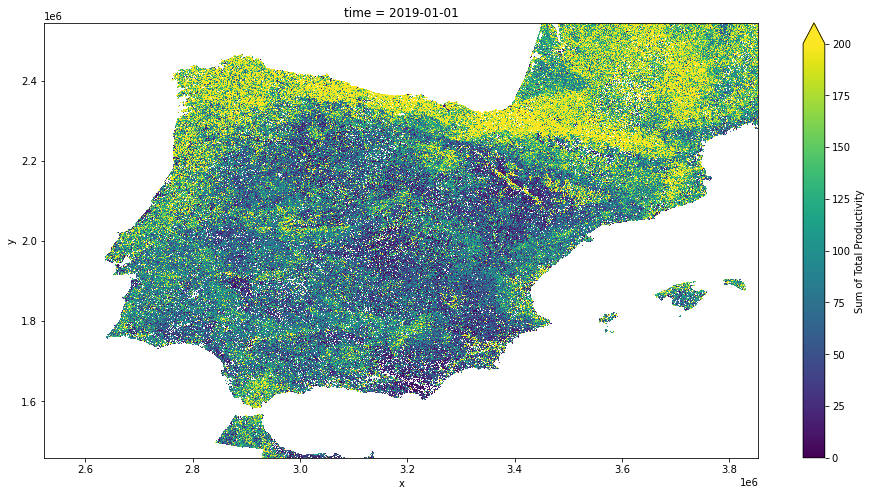

In [8]:
# plot lower resolution layer
dss.datasets[4].tprod_sum.isel(time=2).plot(vmax=200, figsize=[16,8])

In [9]:
# calculate tprod range over three years
tprod_range = dss.datasets[0].tprod_sum.max(dim='time', skipna=True)-dss.datasets[0].tprod_sum.min(dim='time', skipna=True)

In [10]:
# inspect result of this computation 
tprod_range

<xarray.DataArray 'tprod_sum' (y: 108544, x: 133120)>
dask.array<sub, shape=(108544, 133120), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2.523e+06 2.523e+06 2.523e+06 ... 3.855e+06 3.855e+06
  * y        (y) float64 2.544e+06 2.544e+06 2.544e+06 ... 1.459e+06 1.459e+06

In [11]:
tprod_range = xr.Dataset(dict(tprod_range=tprod_range, spatial_ref=dss.datasets[0].spatial_ref))
tprod_range.attrs['title'] = 'Total Productivity range 2017-19'
tprod_range.tprod_range.attrs['grid_mapping'] = 'spatial_ref'
tprod_range.tprod_range.attrs['color_bar_name'] = 'inferno'
tprod_range.tprod_range.attrs['color_value_min'] = '0'
tprod_range.tprod_range.attrs['color_value_max'] = '120'

In [12]:
tprod_range.tprod_range

<xarray.DataArray 'tprod_range' (y: 108544, x: 133120)>
dask.array<sub, shape=(108544, 133120), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2.523e+06 2.523e+06 2.523e+06 ... 3.855e+06 3.855e+06
  * y        (y) float64 2.544e+06 2.544e+06 2.544e+06 ... 1.459e+06 1.459e+06
Attributes:
    grid_mapping:     spatial_ref
    color_bar_name:   inferno
    color_value_min:  0
    color_value_max:  120

In [13]:
#user_store.write_data(data=tprod_range, data_id='TPROD_range_2017_2019.levels', replace=True)

In [14]:
list(user_store.get_data_ids())

['TPROD_range_2017_2019.levels', 'TPROD_range_2017_2019.zarr']

In [15]:
tprod_range = user_store.open_data('TPROD_range_2017_2019.levels')

In [16]:
# make a histogram
count, x = dask.array.histogram(tprod_range.datasets[0].tprod_range,bins=100, range=[0, 750])

In [17]:
# inspect result
count

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [18]:
x = (x[1:]+x[0:-1])/2

In [19]:
# enforce computation, this is the computationally heavy step
y = count.compute()

Text(0.5, 0, 'tprod ranges')

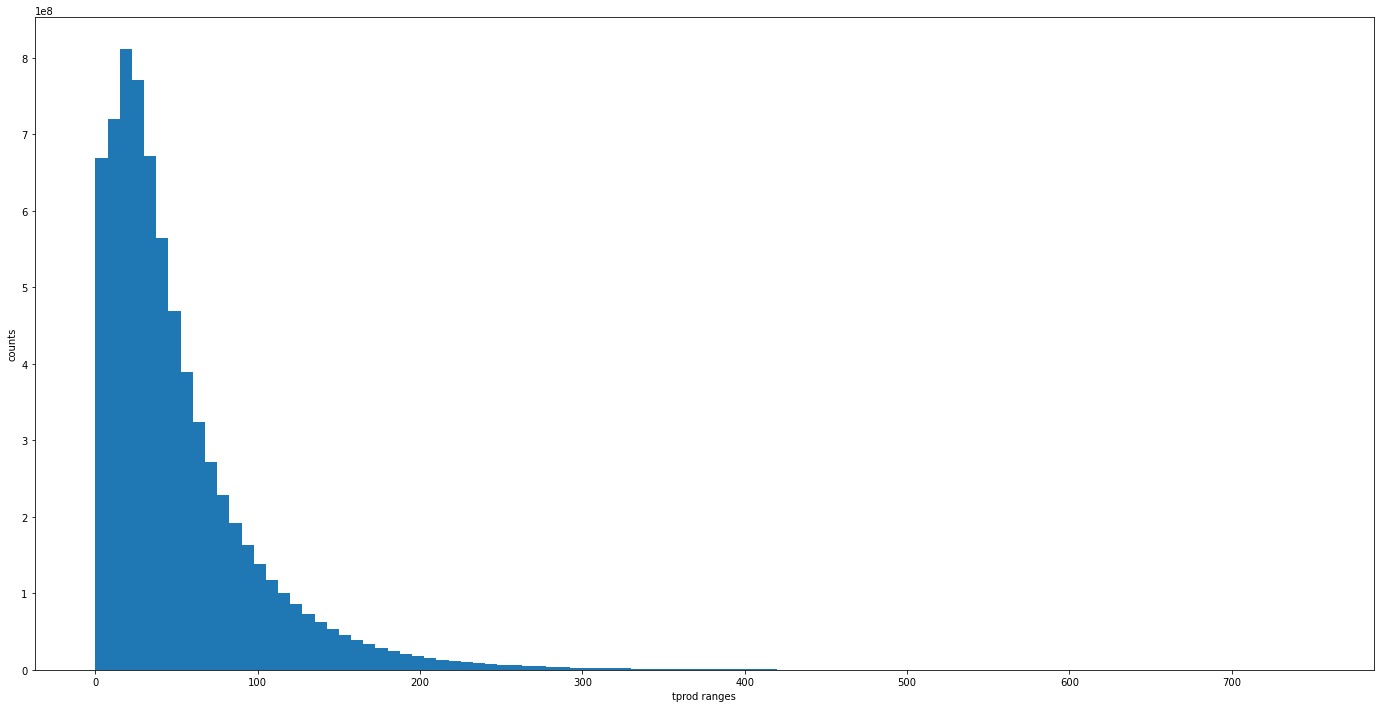

In [20]:
# visualize the result as simple matplotlib barplot
fig = plt.figure(figsize=[24,12])  # create a figure object
ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
ax.bar(x,y,7.5)
ax.set_ylabel('counts')
ax.set_xlabel('tprod ranges')

## Belgium NDVI

In [21]:
EVT = staging_store.open_data('avl/senet/2019/bel/EVAPOTRANSPIRATION_SENET_31UFR.zarr') 

In [22]:
EVT

<xarray.Dataset>
Dimensions:                   (time: 31, y: 5490, x: 5490)
Coordinates:
  * time                      (time) datetime64[ns] 2019-01-21 ... 2019-11-19
  * x                         (x) float32 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                         (y) float32 5.6e+06 5.6e+06 ... 5.49e+06 5.49e+06
Data variables:
    crs                       int32 ...
    daily_evapotranspiration  (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/22)
    Conventions:              CF-1.7
    geospatial_bounds:        POLYGON((600000.0 5600040.0, 600000.0 5490240.0...
    geospatial_bounds_crs:    PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",...
    geospatial_lat_max:       50.54373917381065
    geospatial_lat_min:       49.52841829395487
    geospatial_lat_units:     degrees_north
    ...                       ...
    geospatial_y_units:       metre
    keywords:                 ESA, AVL, Agriculture, EO
    sources:                  ['EVAPOTRANSPIRATION_SENET_31UFR_20190121.ZARR'...
    summary:                  This dataset is used to demonstrate the AVL com...
    time_coverage_start:      2019-01-21 00:00:00
    title:                    Agricultural Virtual Laboratory Dataset

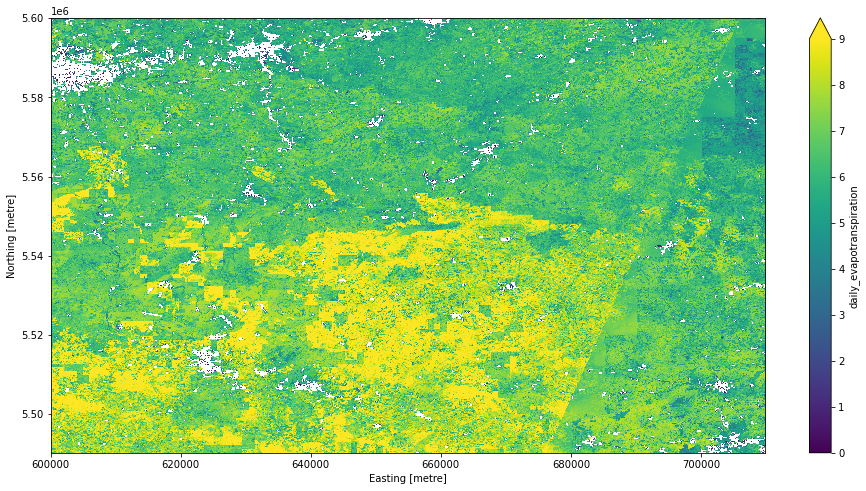

In [23]:
EVT.daily_evapotranspiration.max(dim='time').plot.imshow(figsize=[16,8],vmax=9)

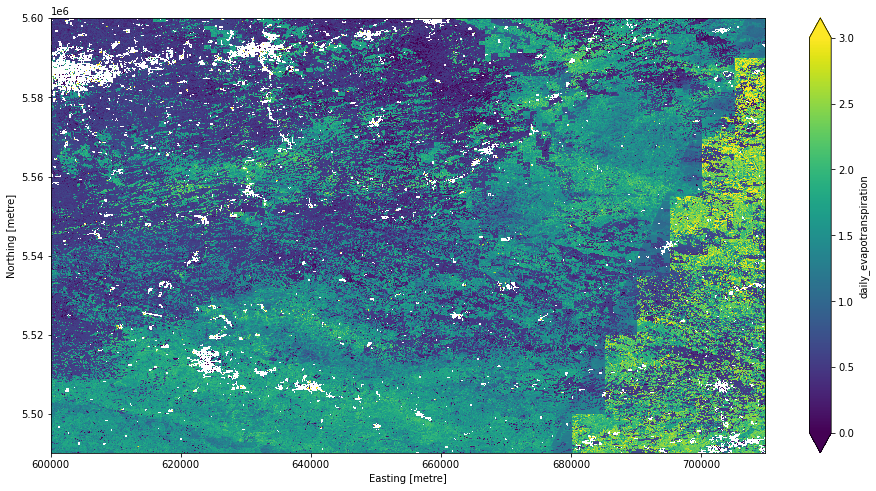

In [24]:
EVT.daily_evapotranspiration.min(dim='time').plot.imshow(figsize=[16,8],vmin = -0., vmax = 3)

In [25]:
# close cluster
cluster.close()